In [96]:
from langchain.chains import TransformChain
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langchain import globals
from langchain_core.runnables import chain
from langchain_core.output_parsers import JsonOutputParser, PydanticOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field
import base64
from dotenv import load_dotenv
load_dotenv(override=True)

# Set verbose
globals.set_debug(True)

In [97]:
class Report(BaseModel):
    """Informazioni su un'immagine."""
    descrizione: str = Field(description="Descrizione dettagliata del rapporto sul problema ecologico. Fornire informazioni solo sul problema ecologico, non sull'ambiente circostante e non aggiungere altri commenti")
    gravità: int = Field(description="Gravità (da 0 a 10) del problema ecologico, ad esempio gravità 9 o 10 in caso di grande discarica a cielo aperto")


In [98]:
parser = PydanticOutputParser(pydantic_object=Report)

In [99]:
def load_image(inputs: dict) -> dict:
    """Load image from file and encode it as base64."""
    image_path = inputs["image_path"]
  
    def encode_image(image_path):
        with open(image_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode('utf-8')
    image_base64 = encode_image(image_path)
    return {"image": image_base64}

Sometimes, when you get a user prompt you’ll want to do some operations on the prompts and have it transformed in a certain way before sending it to the LLM model. 

**TransformChain** provides a way to transform input values to output values using a specified transform function.

In [100]:
load_image_chain = TransformChain(
    input_variables=["image_path"],
    output_variables=["image"],
    transform=load_image
)

In [101]:
parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"description": "Informazioni su un\'immagine.", "properties": {"descrizione": {"title": "Descrizione", "description": "Descrizione dettagliata del rapporto sul problema ecologico. Fornire informazioni solo sul problema ecologico, non sull\'ambiente circostante e non aggiungere altri commenti", "type": "string"}, "gravit\\u00e0": {"title": "Gravit\\u00e0", "description": "Gravit\\u00e0 (da 0 a 10) del problema ecologico, ad esempio gravit\\u00e0 9 o 10 in caso di grande discarica a cielo aperto", "type": "integer"}}, "required": ["desc

In [102]:
@chain
def image_model(inputs: dict) -> str | list[str] | dict:
 """Invoke model with image and prompt."""
 model = ChatOpenAI(temperature=0.1, model="gpt-4o", max_tokens=1024)
 msg = model.invoke(
             [HumanMessage(
             content=[
             {"type": "text", "text": inputs["prompt"]},
             {"type": "text", "text": parser.get_format_instructions()},
             {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{inputs['image']}"}},
             ])]
             )
 return msg.content

In [103]:
def get_image_informations(image_path: str) -> dict:
   vision_prompt = """
      Data l'immagine, fornisci le seguenti informazioni:
      - Descrizione dettagliata della foto e del relativo problema ecologico. Fornire informazioni solo sul problema ecologico, non sull'ambiente circostante e non aggiungere altri commenti. Se la foto non riguarda un problema ecologico resituisci il messaggio "La foto non riguarda un problema ecologico". 
      - Gravità (da 0 a 10) del problema ecologico, ad esempio gravità 9 o 10 in caso di grande discarica a cielo aperto . Se la foto non riguarda un problema ecologico resituisci 0. 
      """
   vision_chain = load_image_chain | image_model | parser
   return vision_chain.invoke({'image_path': f'{image_path}', 
                               'prompt': vision_prompt})

[chain/start] [chain:RunnableSequence] Entering Chain run with input:
{
  "image_path": "C:\\Users\\ELAFACRB1\\Codice\\GitHub\\multimodal-rag\\notebooks\\data\\images\\people.jpg",
  "prompt": "\n      Data l'immagine, fornisci le seguenti informazioni:\n      - Descrizione dettagliata della foto e del relativo problema ecologico. Fornire informazioni solo sul problema ecologico, non sull'ambiente circostante e non aggiungere altri commenti. Se la foto non riguarda un problema ecologico resituisci il messaggio \"La foto non riguarda un problema ecologico\". \n      - Gravità (da 0 a 10) del problema ecologico, ad esempio gravità 9 o 10 in caso di grande discarica a cielo aperto . Se la foto non riguarda un problema ecologico resituisci 0. \n      "
}
[chain/start] [chain:RunnableSequence > chain:TransformChain] Entering Chain run with input:
{
  "image_path": "C:\\Users\\ELAFACRB1\\Codice\\GitHub\\multimodal-rag\\notebooks\\data\\images\\people.jpg",
  "prompt": "\n      Data l'immagin
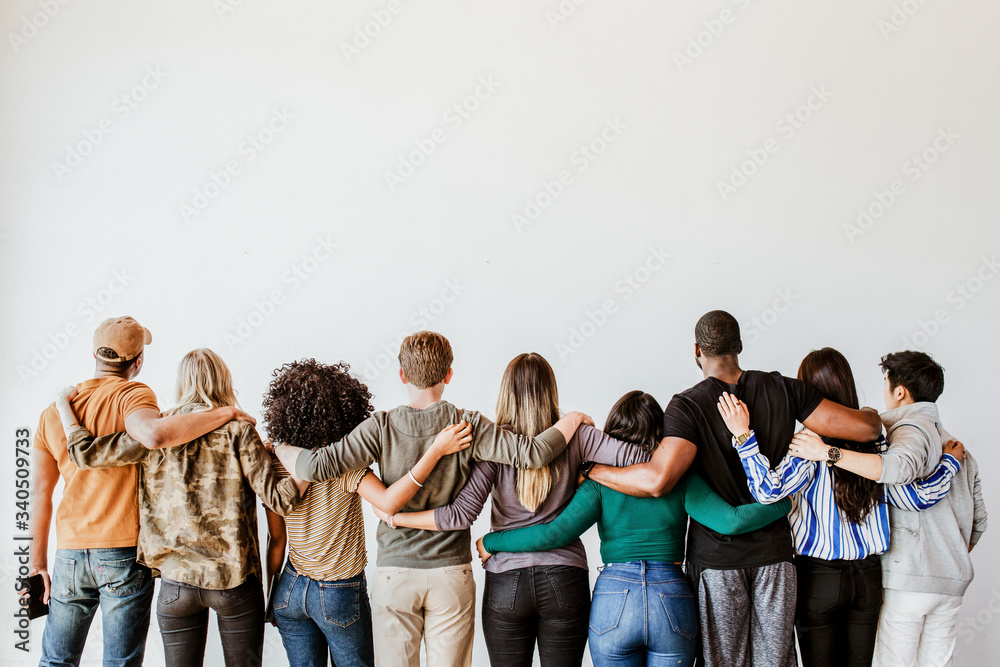

In [104]:
result = get_image_informations(r"C:\Users\ELAFACRB1\Codice\GitHub\multimodal-rag\notebooks\data\images\people.jpg")

In [105]:
print(result.descrizione)
print(result.gravità)

La foto non riguarda un problema ecologico.
0
